In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-cdbhhqsc
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-cdbhhqsc
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"michaeldavidshofer","key":"abb9492fc5ea1fa17378f32dc042592e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ambityga/imagenet100

Dataset URL: https://www.kaggle.com/datasets/ambityga/imagenet100
License(s): unknown


In [ ]:
!unzip imagenet100.zip -d imagenet100_data

Streaming output truncated to the last 5000 lines.
  inflating: imagenet100_data/val.X/n01440764/ILSVRC2012_val_00000293.JPEG  
  inflating: imagenet100_data/val.X/n01440764/ILSVRC2012_val_00002138.JPEG  
  inflating: imagenet100_data/val.X/n01440764/ILSVRC2012_val_00003014.JPEG  
  inflating: imagenet100_data/val.X/n01440764/ILSVRC2012_val_00006697.JPEG  
  inflating: imagenet100_data/val.X/n01440764/ILSVRC2012_val_00007197.JPEG  
  inflating: imagenet100_data/val.X/n01440764/ILSVRC2012_val_00009111.JPEG  
  inflating: imagenet100_data/val.X/n01440764/ILSVRC2012_val_00009191.JPEG  
  inflating: imagenet100_data/val.X/n01440764/ILSVRC2012_val_00009346.JPEG  
  inflating: imagenet100_data/val.X/n01440764/ILSVRC2012_val_00009379.JPEG  
  inflating: imagenet100_data/val.X/n01440764/ILSVRC2012_val_00009396.JPEG  
  inflating: imagenet100_data/val.X/n01440764/ILSVRC2012_val_00010306.JPEG  
  inflating: imagenet100_data/val.X/n01440764/ILSVRC2012_val_00011233.JPEG  
  inflating: imagenet100_

In [ ]:
import os
import csv
import json
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import clip
from transformers import (
    BlipProcessor, BlipForConditionalGeneration,
    AutoProcessor, AutoModelForVision2Seq,
    AutoFeatureExtractor, AutoTokenizer,
    #CocaProcessor, CocaForConditionalGeneration,
    #OFAProcessor, OFAForConditionalGeneration
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 353MiB/s]


In [ ]:
# Load captioning models
blip_proc = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

git_proc = AutoProcessor.from_pretrained("microsoft/git-base")
git_model = AutoModelForVision2Seq.from_pretrained("microsoft/git-base").to(device)

vitgpt2_feat = AutoFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
vitgpt2_model = AutoModelForVision2Seq.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)
vitgpt2_tok = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

#coca_proc  = CocaProcessor.from_pretrained("microsoft/coca-base")
#coca_model = CocaForConditionalGeneration.from_pretrained("microsoft/coca-base").to(device)

#ofa_proc   = OFAProcessor.from_pretrained("OFA-Sys/OFA-base")
#ofa_model  = OFAForConditionalGeneration.from_pretrained("OFA-Sys/OFA-base").to(device)

prompts = [
    "a photo of a {}", "a picture of a {}", "a rendering of a {}",
    "a cropped photo of a {}", "a bright photo of a {}"
]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [ ]:
def get_blip_caption(img):
    x = blip_proc(img, return_tensors="pt").to(device)
    return blip_proc.decode(blip_model.generate(**x)[0], skip_special_tokens=True)

def get_git_caption(img):
    x = git_proc(images=img, return_tensors="pt").to(device)
    return git_proc.batch_decode(git_model.generate(**x), skip_special_tokens=True)[0]

def get_v2_caption(img):
    fe = vitgpt2_feat(images=img, return_tensors="pt")
    pixel_vals = fe["pixel_values"].to(device)
    return vitgpt2_tok.batch_decode(vitgpt2_model.generate(pixel_vals), skip_special_tokens=True)[0]

#def get_ofa_caption(img):
#    img_proc = ofa_proc(images=img, text=" what does the image describe?", return_tensors="pt").to(device)
#    with torch.no_grad():
#        ids = ofa_model.generate(**img_proc, max_length=16)
#    return ofa_proc.batch_decode(ids , skip_special_tokens=True)[0]

#def get_coca_caption(img):
#    img_proc = coca_proc(images=img, return_tensors="pt").to(device)
#    ids = coca_model.generate(**img_proc, max_length=16)
#    return coca_proc.batch_decode(ids , skip_special_tokens=True)[0]

def run_clip_with_prompts(classes, img):
    texts = []
    idx2cls = []
    for cls in classes:
        for t in prompts:
            texts.append(t.format(cls))
            idx2cls.append(cls)
    ii = preprocess(img).unsqueeze(0).to(device)
    ti = clip.tokenize(texts).to(device)
    with torch.no_grad():
        logits,_ = clip_model(ii, ti)
    probs = logits.softmax(-1).cpu()[0]
    sums = {cls:0.0 for cls in classes}
    counts = {cls:0 for cls in classes}
    for i,cls in enumerate(idx2cls):
        sums[cls] += probs[i].item()
        counts[cls] += 1
    avg = {cls: sums[cls]/counts[cls] for cls in classes}
    return max(avg, key=avg.get)

def fuse_and_classify(img, cap, classes):
    ii = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        ifeat = clip_model.encode_image(ii)
        tfeat = clip_model.encode_text(clip.tokenize([cap]).to(device))
    fused = torch.nn.functional.normalize(ifeat + tfeat, dim=-1)
    cf = clip.tokenize(classes).to(device)
    with torch.no_grad():
        cfeat = clip_model.encode_text(cf)
    sims = (fused @ cfeat.T).softmax(-1).cpu()[0]
    return classes[sims.argmax().item()]


In [ ]:
dataset = "imagenet100_data"
os.makedirs(dataset, exist_ok=True)

#print(dataset + "/Labels")

with open(dataset + "/Labels.json") as f:
    true_labels = json.load(f)
    print("Labels found")

Labels found


In [ ]:
classes = sorted({v.split(",")[0].lower() for v in true_labels.values()})
out = "everything_results_200_md.csv"
w = csv.writer(open(out, "w", newline=""))

w.writerow([
    "image","folder","true_label",
    "blip_caption","git_caption","vitgpt2_caption",
    "clip_only","clip_blip","clip_git","clip_v2",
    "fuse_blip","fuse_git","fuse_v2",
    "blip_ok","git_ok","v2_ok",
    "clip_ok","clip_blip_ok","clip_git_ok","clip_v2_ok",
    "fuse_blip_ok","fuse_git_ok","fuse_v2_ok"
])

max_images = 5000
count = 0
totals = {k: 0 for k in [
    "blip","git","v2","clip","clip_blip","clip_git","clip_v2",
    "fuse_blip","fuse_git","fuse_v2"
]}

clip_features = []
clip_labels = []

for fld in sorted(os.listdir(dataset +"/val.X")):
    path = os.path.join(dataset +"/val.X", fld)

    print(path)

    if not os.path.isdir(path): continue
    kws = [w.strip() for w in true_labels[fld].lower().split(",")]

    for imgf in sorted(os.listdir(path)):
        if count >= max_images: break
        if not imgf.lower().endswith((".jpg",".jpeg",".png")): continue
        img_path = os.path.join(path, imgf)
        img = Image.open(img_path).convert("RGB")

        b, g, v = get_blip_caption(img), get_git_caption(img), get_v2_caption(img)
        #coca, ofa = get_coca_caption(img), get_ofa_caption(img)

        c0 = run_clip_with_prompts(classes, img)
        c1 = run_clip_with_prompts([b]+classes, img)
        c2 = run_clip_with_prompts([g]+classes, img)
        c3 = run_clip_with_prompts([v]+classes, img)
        #c4 = run_clip_with_prompts([coca]+classes, img)
        #c5 = run_clip_with_prompts([ofa]+classes, img)

        f1 = fuse_and_classify(img, b, classes)
        f2 = fuse_and_classify(img, g, classes)
        f3 = fuse_and_classify(img, v, classes)
        #f4 = fuse_and_classify(img, coca, classes)
        #f5 = fuse_and_classify(img, ofa, classes)

        ok = lambda p: any(k in p for k in kws)
        flag = {}
        flags = {
            "blip": ok(b.lower()), "git": ok(g.lower()), "v2": ok(v.lower()),
            "clip": ok(c0), "clip_blip": ok(c1), "clip_git": ok(c2), "clip_v2": ok(c3),
            "fuse_blip": ok(f1), "fuse_git": ok(f2), "fuse_v2": ok(f3)
        }

        for k in totals: totals[k] += int(flags[k])
        count += 1

        with torch.no_grad():
            clip_feat = clip_model.encode_image(preprocess(img).unsqueeze(0).to(device))
        clip_features.append(clip_feat.squeeze(0).cpu().numpy())
        clip_labels.append(classes.index(kws[0]))

        w.writerow([
            imgf, fld, true_labels[fld].lower(),
            b, g, v,
            c0, c1, c2, c3, f1, f2, f3,
            flags["blip"], flags["git"], flags["v2"],
            flags["clip"], flags["clip_blip"], flags["clip_git"], flags["clip_v2"],
            flags["fuse_blip"], flags["fuse_git"], flags["fuse_v2"]
        ])
    if count >= max_images: break

w.writerow([])
w.writerow(["ACCURACY","",""] + [f"{totals[k]/count:.2%}" for k in totals])
print("Done", count, "images", out)


imagenet100_data/val.X/n01440764
imagenet100_data/val.X/n01443537
imagenet100_data/val.X/n01484850
imagenet100_data/val.X/n01491361
Done 200 images everything_results_200_md.csv


In [ ]:
fused_features = []
labels = []

for x_dir in ['train.X1']:
    path = os.path.join(dataset, x_dir)
    print(path)
    if not os.path.isdir(path):
        print("error")
        continue

    for fld in sorted(os.listdir(path)):
        class_path = os.path.join(path, fld)
        print(class_path)
        if not os.path.isdir(class_path):
            continue

        kws = [w.strip() for w in true_labels.get(fld, "").lower().split(",")]

        for imgf in sorted(os.listdir(class_path)):
            if not imgf.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(class_path, imgf)
            img = Image.open(img_path).convert("RGB")

            caption = get_git_caption(img)

            with torch.no_grad():
                image_feat = clip_model.encode_image(preprocess(img).unsqueeze(0).to(device))
                text_feat = clip_model.encode_text(clip.tokenize(caption).to(device))

                image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)
                text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)

                fused_feat = torch.cat([image_feat, text_feat], dim=1)

            fused_features.append(fused_feat.squeeze(0).cpu().numpy())
            labels.append(classes.index(kws[0]))

imagenet100_data/train.X1
imagenet100_data/train.X1/n01440764
imagenet100_data/train.X1/n01484850
imagenet100_data/train.X1/n01494475
imagenet100_data/train.X1/n01531178
imagenet100_data/train.X1/n01632777
imagenet100_data/train.X1/n01665541
imagenet100_data/train.X1/n01687978
imagenet100_data/train.X1/n01695060
imagenet100_data/train.X1/n01749939
imagenet100_data/train.X1/n01775062
imagenet100_data/train.X1/n01795545
imagenet100_data/train.X1/n01818515
imagenet100_data/train.X1/n01820546
imagenet100_data/train.X1/n01824575
imagenet100_data/train.X1/n01833805
imagenet100_data/train.X1/n01914609
imagenet100_data/train.X1/n01924916
imagenet100_data/train.X1/n01930112
imagenet100_data/train.X1/n01950731
imagenet100_data/train.X1/n01978455
imagenet100_data/train.X1/n01984695
imagenet100_data/train.X1/n02007558
imagenet100_data/train.X1/n02012849
imagenet100_data/train.X1/n02018795
imagenet100_data/train.X1/n02037110


In [ ]:
torch.save({
    'fused_features': torch.tensor(np.array(fused_features), dtype=torch.float32),
    'labels': torch.tensor(np.array(labels), dtype=torch.long)
}, 'fused_features_labels.pth')



In [ ]:
fused_features_val = []
labels_val = []

val_path = os.path.join(dataset, 'val.X')
print(val_path)

val_path_classes = []

for fld in sorted(os.listdir(val_path)):
    class_path = os.path.join(val_path, fld)
    if not os.path.isdir(class_path):
        continue

    kws = [w.strip() for w in true_labels.get(fld, "").lower().split(",")]
    if not kws or kws[0] == "":
        continue

    val_path_classes.append(kws[0])

    img_files = sorted([
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])[:50]

    for imgf in img_files:
        img_path = os.path.join(class_path, imgf)
        img = Image.open(img_path).convert("RGB")

        caption = get_git_caption(img)
        with torch.no_grad():
            image_feat = clip_model.encode_image(preprocess(img).unsqueeze(0).to(device))
            text_feat = clip_model.encode_text(clip.tokenize(caption).to(device))

            image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)
            text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)

            fused_feat = torch.cat([image_feat, text_feat], dim=1)

        fused_features_val.append(fused_feat.squeeze(0).cpu().numpy())
        labels_val.append(kws[0])

classes = sorted(set(val_classes))
class_to_idx = {c: i for i, c in enumerate(classes)}
labels_val = [class_to_idx[lbl] for lbl in labels_val]

imagenet100_data/val.X


KeyboardInterrupt: 

In [ ]:
torch.save({
    'fused_features': torch.tensor(np.array(fused_features_val), dtype=torch.float32),
    'labels': torch.tensor(np.array(labels_val), dtype=torch.long)
}, 'fused_features_labels_val.pth')

In [ ]:
#Load data
checkpoint = torch.load('fused_features_labels_x2.pth')
fused_features = checkpoint['fused_features_x2']
labels = checkpoint['labels_x2']

In [ ]:
X_tensor = fused_features.clone().detach().float()
y_tensor = labels.clone().detach().long()

print("Min label:", y_tensor.min().item())
print("Max label:", y_tensor.max().item())
print("Number of classes:", len(np.unique(labels)))

print("Label dtype:", y_tensor.dtype)
print("Unique labels:", torch.unique(y_tensor))
print("Max label:", torch.max(y_tensor))
print("Expected classes:", len(np.unique(labels)))

if isinstance(labels, torch.Tensor):
    labels = labels.cpu().numpy()

unique_labels = sorted(set(labels))
label_map = {original: idx for idx, original in enumerate(unique_labels)}

labels_mapped = [label_map[int(lbl)] for lbl in labels]
y_tensor = torch.tensor(labels_mapped, dtype=torch.long)

print("Label dtype:", y_tensor.dtype)
print("Unique labels:", torch.unique(y_tensor))
print("Max label:", torch.max(y_tensor))
print("Expected classes:", len(np.unique(labels)))

X_tensor = X_tensor.clone().detach()
y_tensor = y_tensor.clone().detach()

X_np = X_tensor.cpu().numpy()
print("NaNs:", np.isnan(X_np).any(), "Infs:", np.isinf(X_np).any())
print("Number of Samples/dimension")
print(X_tensor.shape)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
train_ds, test_ds = random_split(dataset, [train_size, len(dataset)-train_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32)

Min label: 0
Max label: 98
Number of classes: 25
Label dtype: torch.int64
Unique labels: tensor([ 0,  4, 11, 16, 24, 25, 31, 32, 35, 39, 41, 43, 50, 55, 56, 59, 60, 63,
        65, 72, 74, 76, 80, 87, 98])
Max label: tensor(98)
Expected classes: 25
Label dtype: torch.int64
Unique labels: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24])
Max label: tensor(24)
Expected classes: 25
NaNs: False Infs: False
Number of Samples/dimension
torch.Size([32500, 1024])


Epoch 1, Loss: 2236.1820
Epoch 2, Loss: 848.3980
Epoch 3, Loss: 409.9173
Epoch 4, Loss: 294.6564
Epoch 5, Loss: 242.2745
Epoch 6, Loss: 211.2278
Epoch 7, Loss: 189.8527
Epoch 8, Loss: 174.6205
Epoch 9, Loss: 162.5222
Epoch 10, Loss: 153.0102
Epoch 11, Loss: 144.2258
Epoch 12, Loss: 137.9120
Epoch 13, Loss: 131.3520
Epoch 14, Loss: 126.5665
Epoch 15, Loss: 122.2975
Epoch 16, Loss: 119.0656
Epoch 17, Loss: 114.3489
Epoch 18, Loss: 111.5058
Epoch 19, Loss: 108.2487
Epoch 20, Loss: 105.7038
Epoch 21, Loss: 103.0800
Epoch 22, Loss: 100.8524
Epoch 23, Loss: 98.2812
Epoch 24, Loss: 96.1767
Epoch 25, Loss: 94.4941
Epoch 26, Loss: 92.4332
Epoch 27, Loss: 90.7961
Epoch 28, Loss: 89.3747
Epoch 29, Loss: 87.6185
Epoch 30, Loss: 86.0068
Epoch 31, Loss: 84.6352
Epoch 32, Loss: 83.9195
Epoch 33, Loss: 82.0506
Epoch 34, Loss: 80.3829
Epoch 35, Loss: 78.8871
Epoch 36, Loss: 78.4952
Epoch 37, Loss: 76.8930
Epoch 38, Loss: 75.6328
Epoch 39, Loss: 74.7148
Epoch 40, Loss: 74.2220
Epoch 41, Loss: 72.6629
Ep

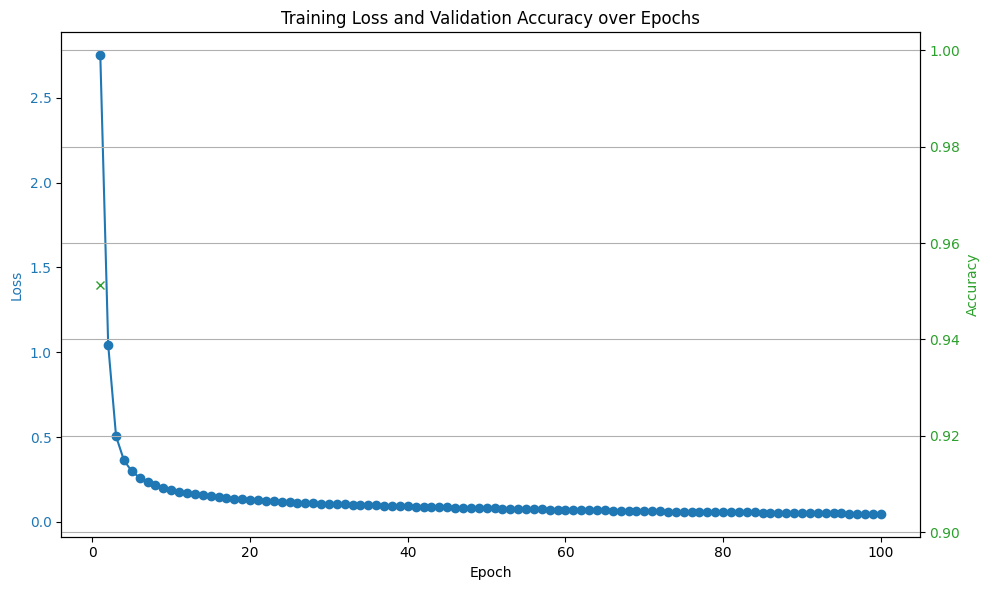

Test Accuracy: 95.14%


In [ ]:
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

num_classes = len(set(labels_mapped))
model = Classifier(X_tensor.shape[1], num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_values = []
accuracy_values = []

#Train
for epoch in range(100):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb, yb
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

#Plot loss
#plt.figure(figsize=(8, 5))
#plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', color='b')
#plt.title("Training Loss over Epochs")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.grid(True)
#plt.show()

#Evaluate
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb, yb
        preds = model(xb).argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    acc = correct / total
    accuracy_values.append(acc)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color)
ax1.plot(range(1, len(loss_values) + 1), loss_values, marker='o', color=color, label="Loss")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel("Accuracy", color=color)
ax2.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='x', color=color, label="Accuracy")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Training Loss and Validation Accuracy over Epochs")
fig.tight_layout()
plt.grid(True)
plt.show()

print(f"Test Accuracy: {correct / total:.2%}")

Extra